In [3]:
!pip install --upgrade scikit-learn tensorflow matplotlib joblib


In [5]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.datasets import fashion_mnist
import joblib

%matplotlib inline


In [7]:
# load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


Shapes: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


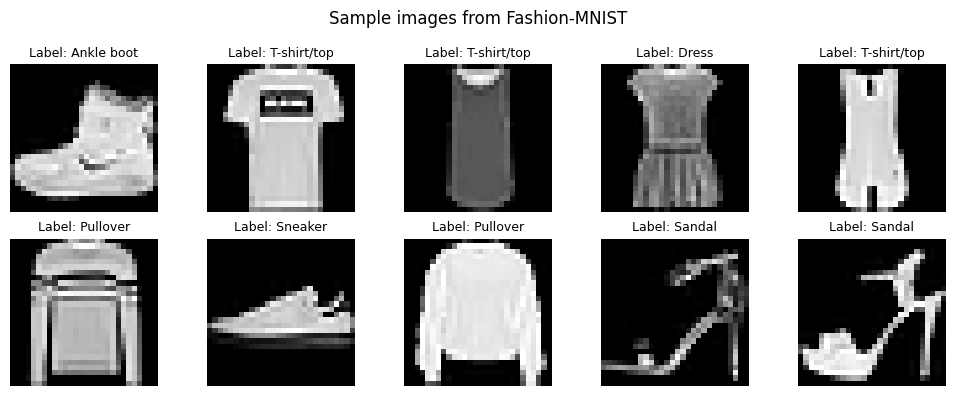

In [9]:
# show the first 10 training images (2x5 grid)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {class_names[y_train[i]]}', fontsize=9)
    ax.axis('off')

plt.suptitle('Sample images from Fashion-MNIST', fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
# flatten pixels and scale to [0,1]
X_train_flat = X_train.reshape(-1, 28*28).astype("float32") / 255.0
X_test_flat  = X_test.reshape(-1, 28*28).astype("float32") / 255.0

# Optional: create a small validation split from the training set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_flat, y_train, test_size=0.10, stratify=y_train, random_state=42)
print("Train_sub shape:", X_train_sub.shape, "Val shape:", X_val.shape)


Train_sub shape: (54000, 784) Val shape: (6000, 784)


In [13]:
# instantiate & train a Decision Tree
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=40,         # reasonable starting cap
    min_samples_leaf=5,   # avoid tiny leaves
    random_state=42
)

t0 = time.time()
dt.fit(X_train_sub, y_train_sub)
t1 = time.time()
print(f"Trained DecisionTree in {t1-t0:.2f} seconds")


Trained DecisionTree in 70.35 seconds


In [15]:
# Cell 6: quick accuracy checks
for name, X, y in [('Validation', X_val, y_val), ('Test', X_test_flat, y_test)]:
    y_pred = dt.predict(X)
    print(f"{name} accuracy: {accuracy_score(y, y_pred):.4f}")


Validation accuracy: 0.8103
Test accuracy: 0.8048


              precision    recall  f1-score   support

 T-shirt/top       0.75      0.77      0.76      1000
     Trouser       0.96      0.95      0.96      1000
    Pullover       0.67      0.69      0.68      1000
       Dress       0.82      0.80      0.81      1000
        Coat       0.68      0.68      0.68      1000
      Sandal       0.91      0.90      0.90      1000
       Shirt       0.56      0.55      0.56      1000
     Sneaker       0.88      0.89      0.88      1000
         Bag       0.93      0.91      0.92      1000
  Ankle boot       0.90      0.91      0.91      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.81     10000
weighted avg       0.81      0.80      0.81     10000



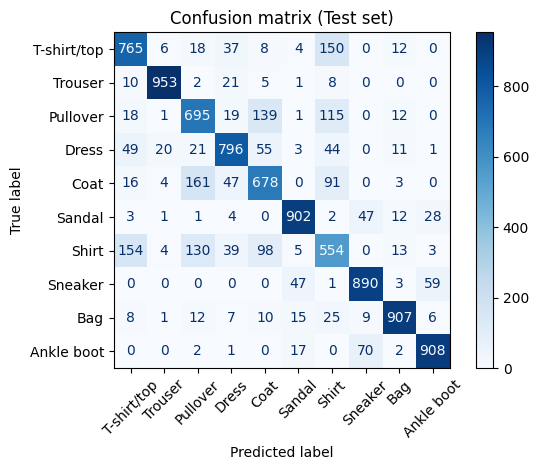

In [17]:
# classification report & confusion matrix on test set
y_test_pred = dt.predict(X_test_flat)
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion matrix (visual)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=class_names, xticks_rotation=45, cmap='Blues', normalize=None)
plt.title("Confusion matrix (Test set)")
plt.tight_layout()
plt.show()


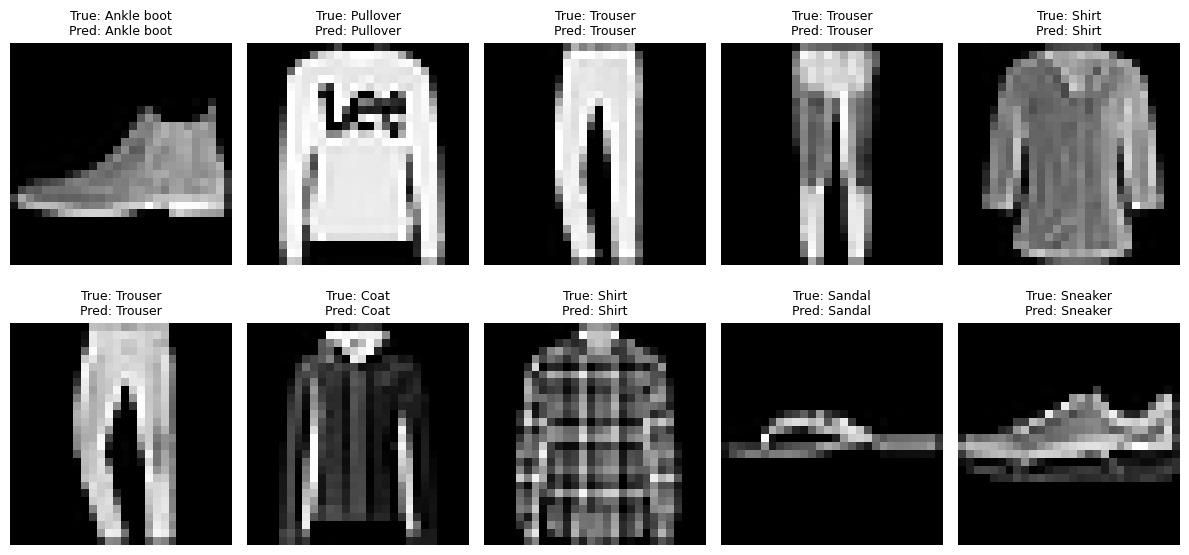

In [19]:
# show 10 test images with true & predicted labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {class_names[y_test[i]]}\nPred: {class_names[y_test_pred[i]]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()


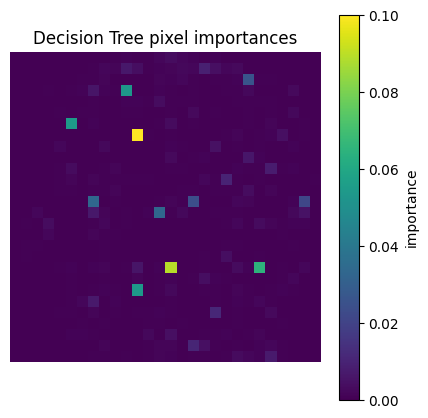

In [22]:
# feature importances as 28x28 image
importances = dt.feature_importances_
imp_img = importances.reshape(28, 28)

plt.figure(figsize=(5, 5))
plt.imshow(imp_img, interpolation='nearest')
plt.title("Decision Tree pixel importances")
plt.colorbar(label='importance')
plt.axis('off')
plt.show()


In [21]:
# GridSearch (small grid); adjust for your CPU and patience
param_grid = {
    "max_depth": [10, 20, 30, 40, None],
    "min_samples_leaf": [1, 2, 5, 10]
}

gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Use the smaller training subset to speed this up
gs.fit(X_train_sub, y_train_sub)
print("Best params:", gs.best_params_)
best_dt = gs.best_estimator_
print("Validation best CV:", gs.best_score_)
print("Test accuracy (best):", accuracy_score(y_test, best_dt.predict(X_test_flat)))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'min_samples_leaf': 5}
Validation best CV: 0.8046481481481482
Test accuracy (best): 0.7999


In [22]:
# quick Random Forest (may be slower but usually much more accurate)
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
t0 = time.time()
rf.fit(X_train_sub, y_train_sub)
t1 = time.time()
print(f"RandomForest trained in {t1-t0:.2f}s - Test acc: {accuracy_score(y_test, rf.predict(X_test_flat)):.4f}")


RandomForest trained in 23.69s - Test acc: 0.8746


In [23]:
# saving the trained decision tree
joblib.dump(dt, "fashion_dt_baseline.joblib")
# to load: dt = joblib.load("fashion_dt_baseline.joblib")


['fashion_dt_baseline.joblib']

In [28]:
# smaller subset for fast prototyping
rng = np.random.RandomState(42)
small_idx = rng.choice(len(X_train_flat), size=10000, replace=False)
X_small = X_train_flat[small_idx]
y_small = y_train[small_idx]

# Train on small subset (fast)
dt_small = DecisionTreeClassifier(max_depth=30, min_samples_leaf=3, random_state=42)
dt_small.fit(X_small, y_small)
print("Small-subset test acc:", accuracy_score(y_test, dt_small.predict(X_test_flat)))


Small-subset test acc: 0.7552


In [32]:
#Training Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression (multinomial, saga solver works for large datasets)
log_reg = LogisticRegression(
    penalty="l2",
    solver="saga",
    multi_class="multinomial",
    max_iter=100,
    n_jobs=-1,
    random_state=42
)

log_reg.fit(X_train_flat, y_train)

# Evaluate
y_pred_lr = log_reg.predict(X_test_flat)
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, target_names=class_names))


C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Test Accuracy: 0.8438

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.80      0.81      0.80      1000
     Trouser       0.97      0.96      0.96      1000
    Pullover       0.73      0.74      0.73      1000
       Dress       0.83      0.87      0.85      1000
        Coat       0.74      0.76      0.75      1000
      Sandal       0.95      0.92      0.93      1000
       Shirt       0.63      0.57      0.60      1000
     Sneaker       0.91      0.94      0.92      1000
         Bag       0.93      0.94      0.93      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [36]:
# Decision Tree results in y_test_pred
acc_dt = accuracy_score(y_test, y_test_pred)
acc_lr = accuracy_score(y_test, y_pred_lr)

print("Decision Tree Test Accuracy:", acc_dt)
print("Logistic Regression Test Accuracy:", acc_lr)


Decision Tree Test Accuracy: 0.8048
Logistic Regression Test Accuracy: 0.8438


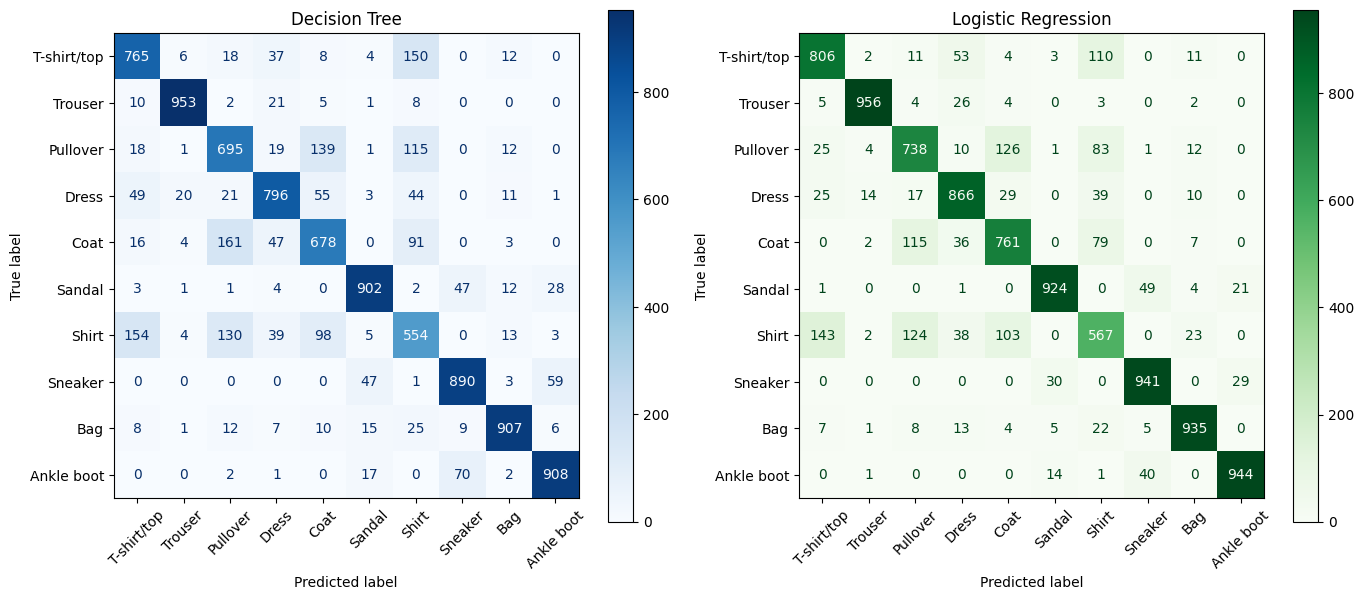

In [38]:
#Visual Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Decision Tree
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=class_names, xticks_rotation=45, cmap='Blues', ax=axes[0]
)
axes[0].set_title("Decision Tree")

# Logistic Regression
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr, display_labels=class_names, xticks_rotation=45, cmap='Greens', ax=axes[1]
)
axes[1].set_title("Logistic Regression")

plt.tight_layout()
plt.show()


In [ ]:
#Applying L1 and L2 regularization to logistic regression.
#Observing effects on generalization, overfitting, and decision boundaries.

!pip install --upgrade scikit-learn tensorflow matplotlib joblib

import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

from tensorflow.keras.datasets import fashion_mnist

%matplotlib inline

# Make plots prettier
sns.set(style="whitegrid")



In [42]:
# Load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Flatten and scale
X = np.vstack([X_train, X_test]).astype("float32") / 255.0
y = np.hstack([y_train, y_test])

# Create a train / validation / test split (to measure generalization properly)
X_temp, X_test_final, y_temp, y_test_final = train_test_split(
    X, y, test_size=10000, stratify=y, random_state=42
)
# From the remaining 60000, split train/val 90/10
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_temp, y_temp, test_size=0.10, stratify=y_temp, random_state=42
)

# Flatten for linear models
X_train_flat = X_train_full.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test_final.reshape(-1, 28*28)

print("Shapes (train/val/test):", X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)
class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]


Shapes (train/val/test): (54000, 784) (6000, 784) (10000, 784)


In [ ]:
# Helper function: train & evaluate a logistic model
def train_eval_logistic(X_train, y_train, X_val, y_val, X_test, y_test,
                        penalty='l2', C=1.0, max_iter=2000, verbose=False):
    """
    Train multinomial Logistic Regression with given penalty and C (inverse reg. strength).
    Returns dict with model, train_acc, val_acc, test_acc, sparsity (#zero coeffs), time_taken
    """
    solver = 'saga'  # saga supports l1 and l2 multinomial
    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        multi_class='multinomial',
        max_iter=max_iter,
        n_jobs=-1,
        random_state=42
    )
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    # sparsity: proportion of coefficients that are exactly zero (only meaningful for L1)
    coef = model.coef_  # shape (10, 784)
    n_total = coef.size
    n_zero = np.sum(np.isclose(coef, 0.0))
    sparsity = n_zero / n_total
    return {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'sparsity': sparsity,
        'time': t1 - t0,
        'coef': coef
    }


In [ ]:
#Sweep C (inverse reg strength) for L1 and L2, record metrics

Cs = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # try small to large -> strong to weak regularization
results = {'l1': [], 'l2': []}

for penalty in ['l1', 'l2']:
    print(f"\n--- Penalty: {penalty} ---")
    for C in Cs:
        print(f"Training penalty={penalty}, C={C} ...", end=' ')
        res = train_eval_logistic(X_train_flat, y_train_full, X_val_flat, y_val, X_test_flat, y_test_final,
                                  penalty=penalty, C=C, max_iter=2000)
        results[penalty].append((C, res))
        print(f"done (val_acc={res['val_acc']:.4f}, test_acc={res['test_acc']:.4f}, sparsity={res['sparsity']:.3f})")



--- Penalty: l1 ---
Training penalty=l1, C=0.01 ... 

C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


done (val_acc=0.8133, test_acc=0.8092, sparsity=0.926)
Training penalty=l1, C=0.1 ... 

C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


done (val_acc=0.8475, test_acc=0.8506, sparsity=0.797)
Training penalty=l1, C=0.5 ... 

C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


done (val_acc=0.8535, test_acc=0.8524, sparsity=0.593)
Training penalty=l1, C=1.0 ... 

C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


done (val_acc=0.8535, test_acc=0.8519, sparsity=0.457)
Training penalty=l1, C=5.0 ... 

C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


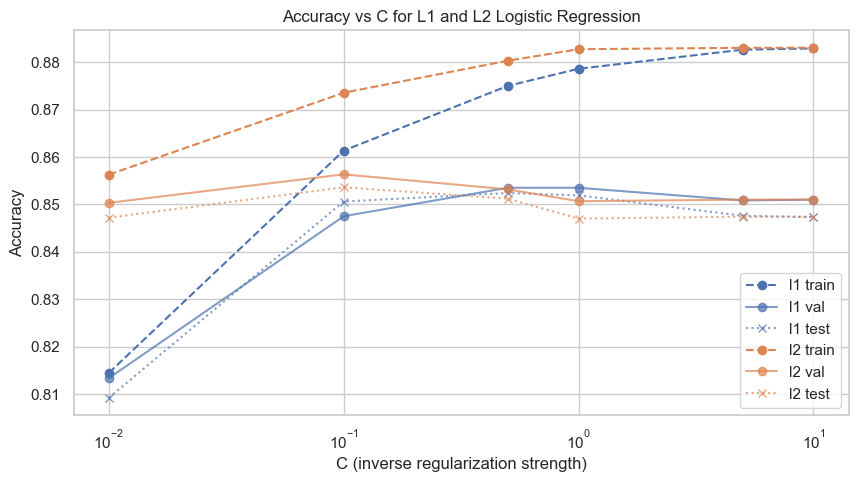

In [ ]:
#Plot accuracy vs C (log-scale) for L1 and L2 (train/val/test) 
import math
plt.figure(figsize=(10, 5))
for penalty, color in [('l1','C0'), ('l2','C1')]:
    Cs_vals = [r[0] for r in results[penalty]]
    train_acc = [r[1]['train_acc'] for r in results[penalty]]
    val_acc = [r[1]['val_acc'] for r in results[penalty]]
    test_acc = [r[1]['test_acc'] for r in results[penalty]]
    plt.plot(Cs_vals, train_acc, marker='o', linestyle='--', label=f'{penalty} train', color=color)
    plt.plot(Cs_vals, val_acc, marker='o', linestyle='-', label=f'{penalty} val', color=color, alpha=0.7)
    plt.plot(Cs_vals, test_acc, marker='x', linestyle=':', label=f'{penalty} test', color=color, alpha=0.7)

plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for L1 and L2 Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()


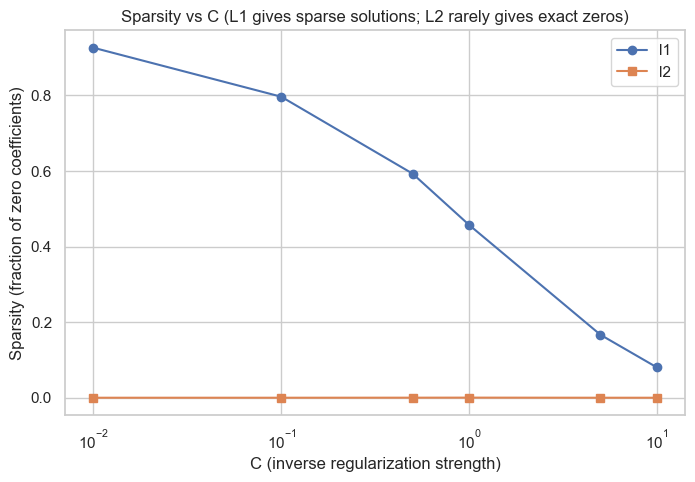

In [ ]:
#Plot sparsity (#zero coeffs) vs C for L1 and L2
plt.figure(figsize=(8,5))
for penalty, marker in [('l1','o'), ('l2','s')]:
    Cs_vals = [r[0] for r in results[penalty]]
    sparsities = [r[1]['sparsity'] for r in results[penalty]]
    plt.plot(Cs_vals, sparsities, marker=marker, label=penalty)

plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Sparsity (fraction of zero coefficients)')
plt.title('Sparsity vs C (L1 gives sparse solutions; L2 rarely gives exact zeros)')
plt.legend()
plt.grid(True)
plt.show()


Penalty=l1, C=0.01, val_acc=0.8133, sparsity=0.926


C:\Users\perci\AppData\Local\Temp\ipykernel_42636\505133814.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


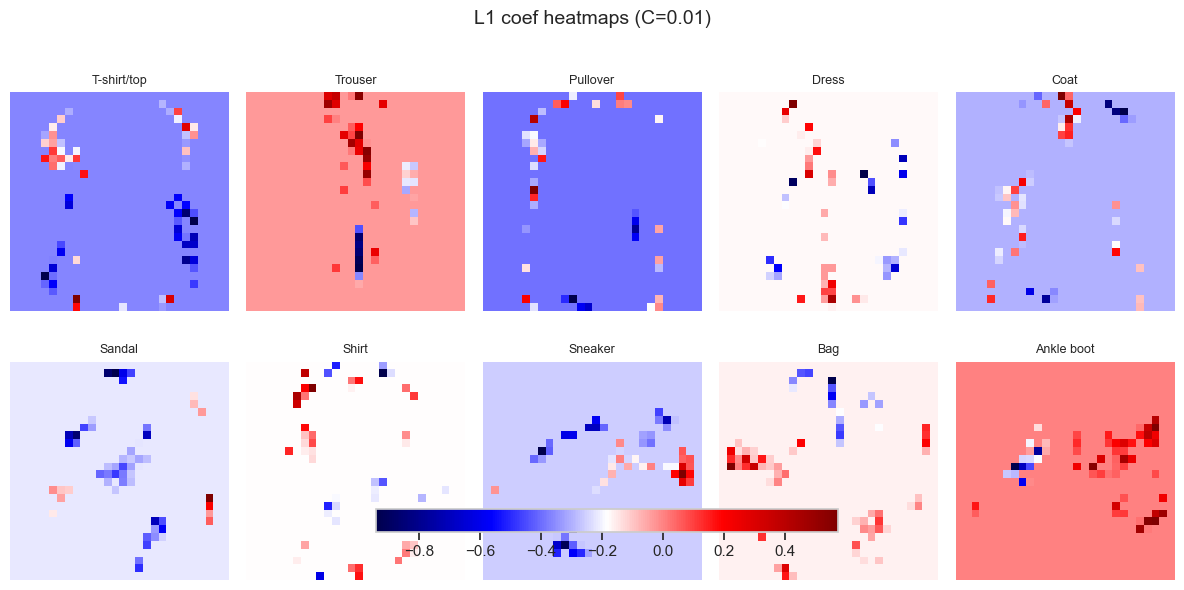

Penalty=l1, C=0.1, val_acc=0.8475, sparsity=0.797


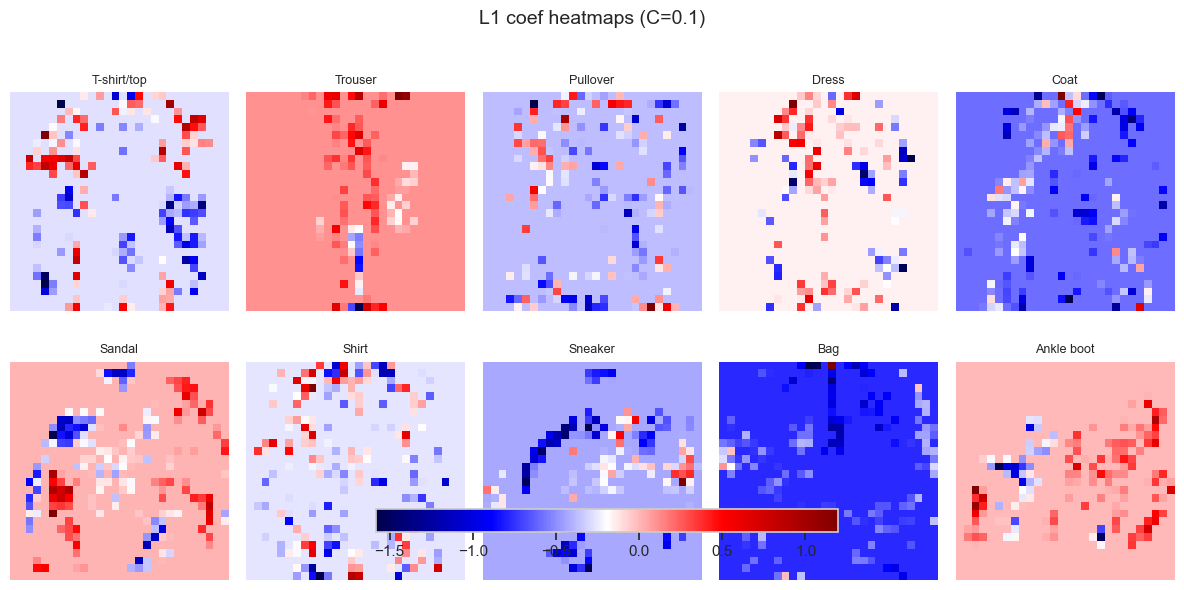

Penalty=l1, C=1.0, val_acc=0.8535, sparsity=0.457


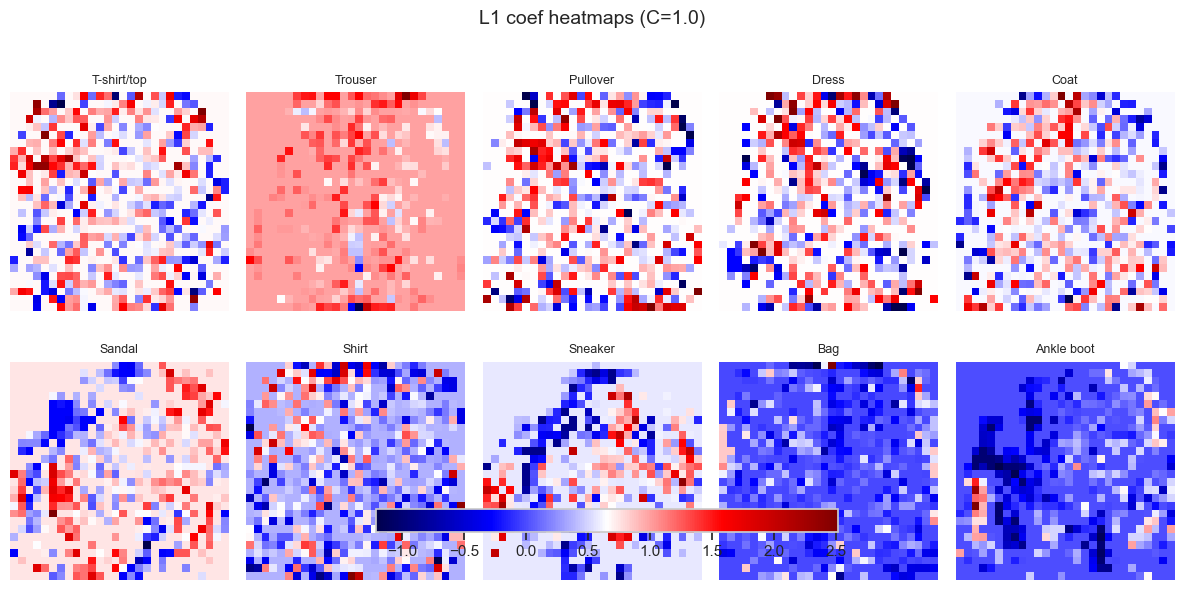

Penalty=l1, C=10.0, val_acc=0.8510, sparsity=0.080


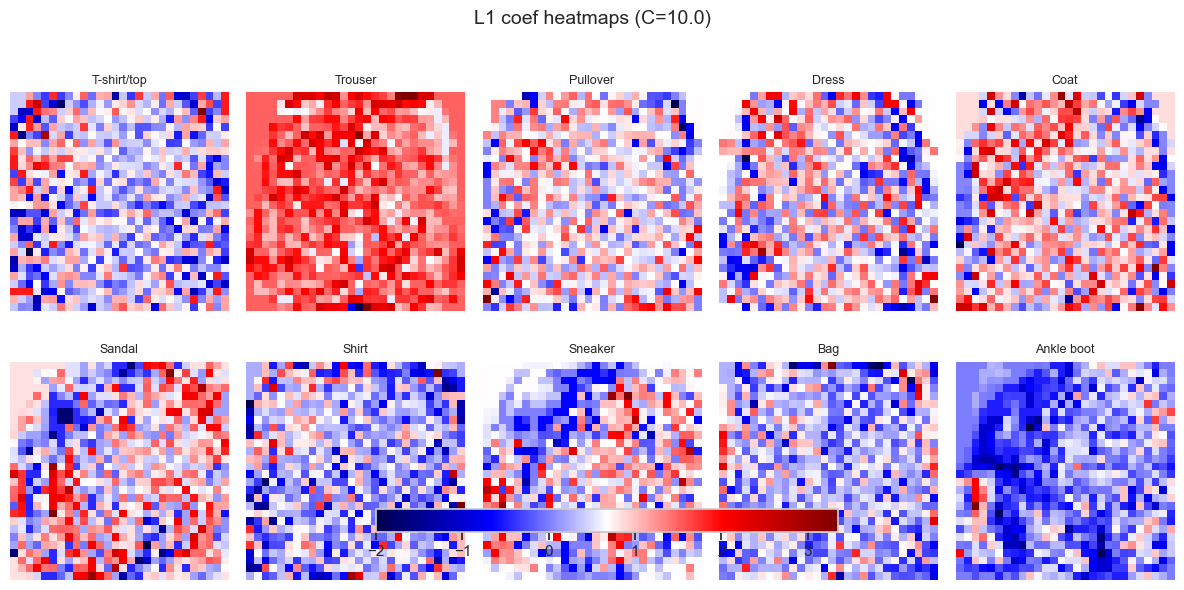

Penalty=l2, C=0.01, val_acc=0.8503, sparsity=0.000


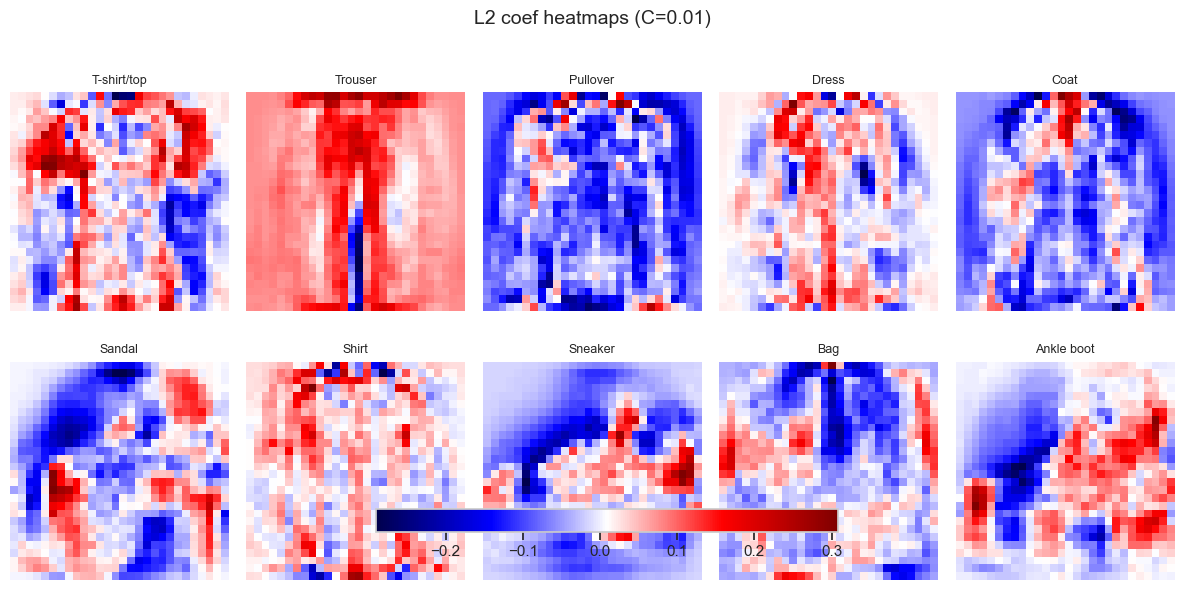

Penalty=l2, C=0.1, val_acc=0.8563, sparsity=0.000


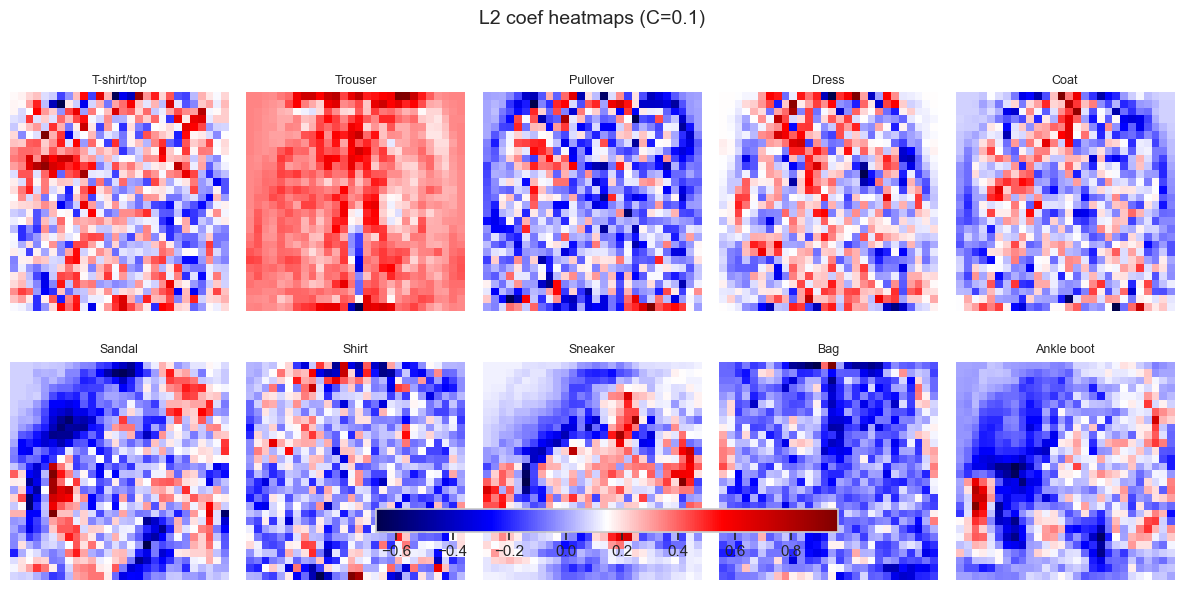

Penalty=l2, C=1.0, val_acc=0.8507, sparsity=0.000


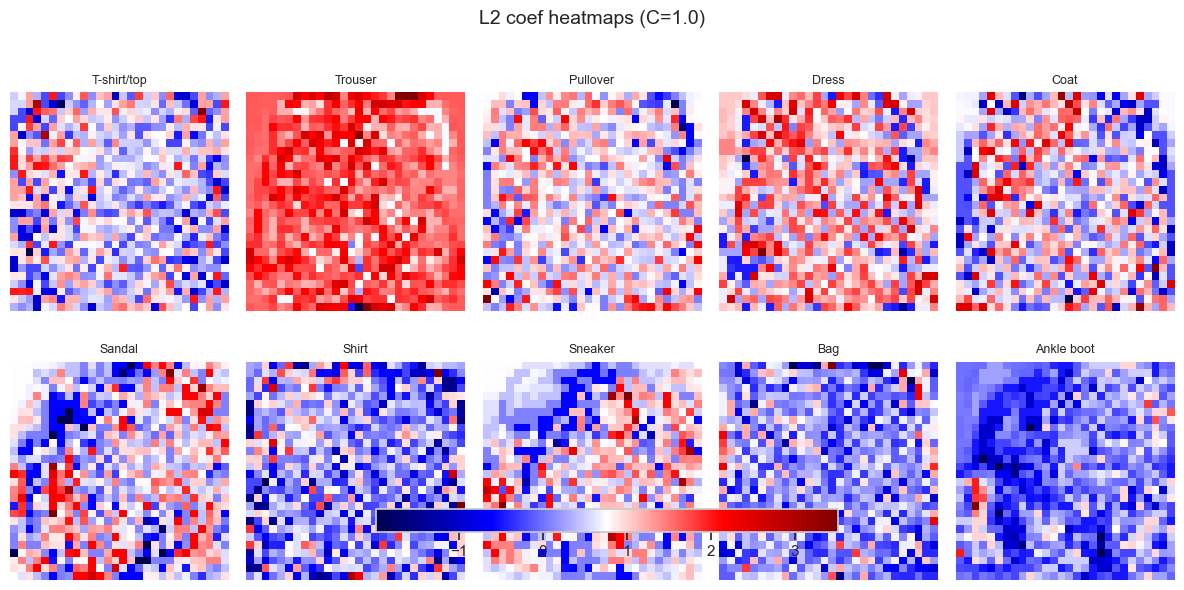

Penalty=l2, C=10.0, val_acc=0.8510, sparsity=0.000


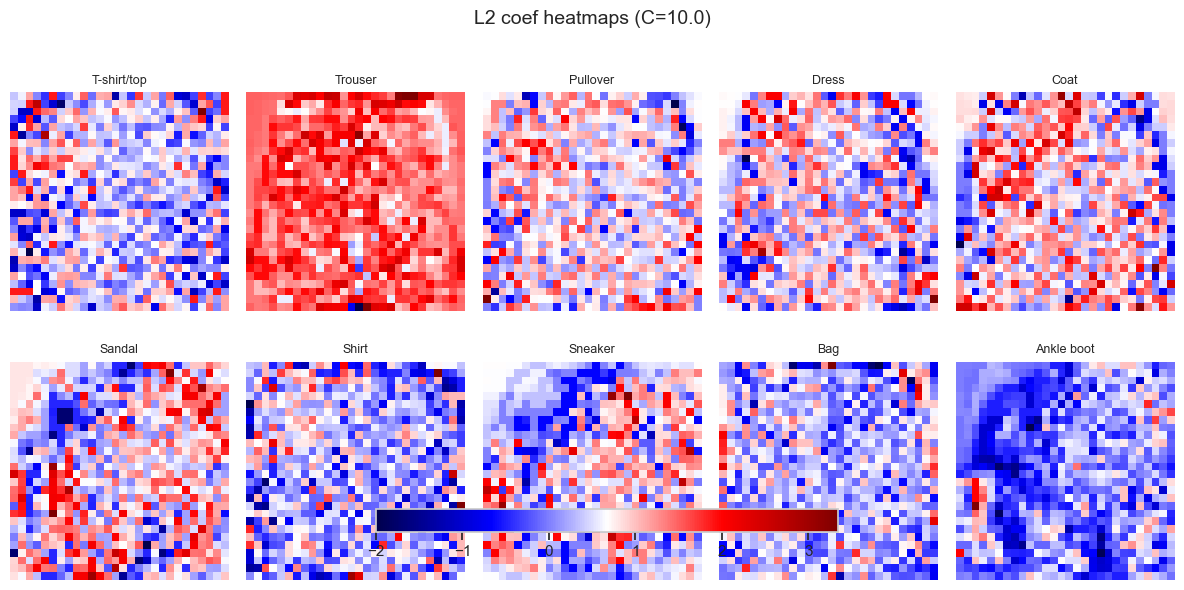

In [ ]:
# Heatmaps of coefficients for selected Cs
def plot_coef_heatmaps(coef, title_prefix=""):
    # coef shape: (10, 784)
    coefs_img = coef.reshape(10, 28, 28)
    fig, axes = plt.subplots(2, 5, figsize=(12,6))
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(coefs_img[i], cmap='seismic', interpolation='nearest')
        ax.set_title(class_names[i], fontsize=9)
        ax.axis('off')
    fig.suptitle(title_prefix, fontsize=14)
    fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.tight_layout()
    plt.show()

# Choose representative Cs (strong reg, medium, weak)
chosen_Cs = [0.01, 0.1, 1.0, 10.0]
for penalty in ['l1', 'l2']:
    for C in chosen_Cs:
        # find the result
        res = next(r[1] for r in results[penalty] if np.isclose(r[0], C))
        print(f"Penalty={penalty}, C={C}, val_acc={res['val_acc']:.4f}, sparsity={res['sparsity']:.3f}")
        plot_coef_heatmaps(res['coef'], title_prefix=f"{penalty.upper()} coef heatmaps (C={C})")


Explained variance by 2 components: 0.46745571


C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\perci\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\perci\AppData\Local\Temp\ipykernel_42636\858792032.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Ma

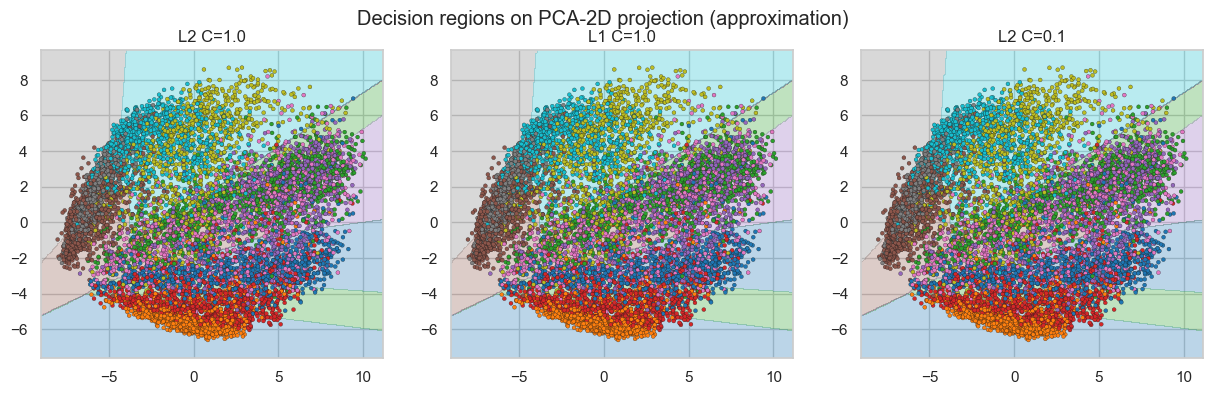

In [ ]:
#PCA 2D projection and decision boundary visualization

# PCA fit (use a subset for speed)
pca = PCA(n_components=2, random_state=42)
# Fit PCA on training data (flattened)
pca.fit(X_train_flat)

# Project train, val, test
X_train_2d = pca.transform(X_train_flat)
X_val_2d = pca.transform(X_val_flat)
X_test_2d = pca.transform(X_test_flat)

print("Explained variance by 2 components:", pca.explained_variance_ratio_.sum())

# Helper to train logistic on 2D for plotting decision regions
from matplotlib.colors import ListedColormap
def plot_decision_regions_2d(X2, y, models_dict, title):
    # X2: data to plot (2D); models_dict: {'label': sklearn_model}
    x_min, x_max = X2[:,0].min()-1, X2[:,0].max()+1
    y_min, y_max = X2[:,1].min()-1, X2[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    n_models = len(models_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models==1:
        axes = [axes]
    for ax, (label, model) in zip(axes, models_dict.items()):
        Z = model.predict(grid)
        Z = Z.reshape(xx.shape)
        cmap = ListedColormap(plt.cm.get_cmap('tab10').colors)
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
        sc = ax.scatter(X2[:,0], X2[:,1], c=y, s=8, cmap=cmap, edgecolor='k', linewidth=0.2)
        ax.set_title(label)
    plt.suptitle(title)
    plt.show()

# Train 3 small logistic models on the 2D PCA representation (for visualization only)
models_2d = {}
for penalty, C in [('l2', 1.0), ('l1', 1.0), ('l2', 0.1)]:
    key = f"{penalty.upper()} C={C}"
    lr2 = LogisticRegression(penalty=penalty, C=C, solver='saga', multi_class='multinomial', max_iter=2000)
    lr2.fit(X_train_2d, y_train_full)
    models_2d[key] = lr2

plot_decision_regions_2d(X_test_2d, y_test_final, models_2d, title="Decision regions on PCA-2D projection (approximation)")


In [ ]:
# Pick best val-acc models from our earlier sweep for L1 & L2
best_l1 = max(results['l1'], key=lambda item: item[1]['val_acc'])[1]
best_l2 = max(results['l2'], key=lambda item: item[1]['val_acc'])[1]

print("Best L1 (val) -> C:", next(c for c,r in results['l1'] if r==best_l1))
print("Best L1 val/test acc:", best_l1['val_acc'], best_l1['test_acc'], "sparsity:", best_l1['sparsity'])

print("Best L2 (val) -> C:", next(c for c,r in results['l2'] if r==best_l2))
print("Best L2 val/test acc:", best_l2['val_acc'], best_l2['test_acc'], "sparsity:", best_l2['sparsity'])

# Detailed classification reports on test for both
from sklearn.metrics import classification_report
print("\nL1 Best - Classification Report (test):\n")
print(classification_report(y_test_final, best_l1['model'].predict(X_test_flat), target_names=class_names))

print("\nL2 Best - Classification Report (test):\n")
print(classification_report(y_test_final, best_l2['model'].predict(X_test_flat), target_names=class_names))


Best L1 (val) -> C: 0.5
Best L1 val/test acc: 0.8535 0.8524 sparsity: 0.5931122448979592
Best L2 (val) -> C: 0.1
Best L2 val/test acc: 0.8563333333333333 0.8536 sparsity: 0.0

L1 Best - Classification Report (test):

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.84      0.81      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.76      0.74      0.75      1000
       Dress       0.84      0.86      0.85      1000
        Coat       0.74      0.81      0.78      1000
      Sandal       0.94      0.94      0.94      1000
       Shirt       0.64      0.55      0.59      1000
     Sneaker       0.93      0.93      0.93      1000
         Bag       0.96      0.95      0.95      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


L2 Best - Classificatio